In [1]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import Counter
import keras
from keras import models
from keras import layers
import visualkeras 
from PIL import ImageFont
from PIL import ImageDraw
import pydub
from pydub import AudioSegment
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")

In [ ]:
src_dir = '../dataset/'
dst_dir = '../dataset_wav'
print(os.listdir(src_dir))
# print(os.listdir(dst_dir))

['Ardhito Pramono_Dancing In September.mp3', 'Ed Sheeran_Supermarket Flowers.mp3', 'GANGGA_Whiskey Bottle.mp3', 'Giveon_Heartbreak Anniversary.mp3', 'Gracie Abrams_That’s So True.mp3', 'Keshi_UNDERSTAND.mp3', 'Labrinth_Jealous.mp3', 'Lady Gaga_Die With A Smile.mp3', 'Lauv_First Heartbreak.mp3', 'Lukas Graham_Love Someone.mp3', 'Rich Brian_100 Degrees.mp3', 'Ricky Montgomery_This December.mp3']
['Ardhito Pramono_Dancing In September', 'Ed Sheeran_Supermarket Flowers', 'GANGGA_Whiskey Bottle', 'Giveon_Heartbreak Anniversary', 'Gracie Abrams_That’s So True', 'Keshi_UNDERSTAND', 'Labrinth_Jealous', 'Lady Gaga_Die With A Smile', 'Lauv_First Heartbreak', 'Lukas Graham_Love Someone', 'Rich Brian_100 Degrees', 'Ricky Montgomery_This December']


In [ ]:
SAMPLE_RATE = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
file_list = []

In [ ]:
def convert_mp3_to_wav(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        labels = set()

        for file_name in os.listdir(src_dir):
            if file_name.endswith('.mp3'):
                sub_dir = os.path.join(dst_dir, file_name.replace('.mp3', ''))
                if not os.path.exists(sub_dir):
                    os.makedirs(sub_dir)

                mp3_path = os.path.join(src_dir, file_name)
                wav_path = os.path.join(sub_dir, file_name.replace('.mp3', '.wav'))

                try:
                    audio = AudioSegment.from_mp3(mp3_path)
                    audio.export(wav_path, format='wav')
                    # print(f"Converted {mp3_path} to {wav_path}")
                    file_list.append(wav_path)
                    
                    if "_" in file_name:
                        artist, song = file_name.replace('.mp3', '').split("_", 1)
                        label = f"{artist} - {song}"
                        labels.add(label)  
                except Exception as e:
                    print(f"Failed to convert {mp3_path}: {e}")

        with open('labels.txt', 'w') as f:
            for label in labels: 
                f.write(label + "\n")
    else:
        print(f"{dst_dir} already exists, skipping...")   

def crop_wav(wav_dir, segment_duration=5000, num_segments_per_file=NUM_SEGMENTS):
    for root, _, files in os.walk(wav_dir):
        for file_name in files:
            if file_name.endswith('.wav') and '_segment_' not in file_name:  
                wav_path = os.path.join(root, file_name)
                
                base_name = file_name.replace('.wav', '')
                segments_exist = any(f.startswith(f"{base_name}_segment_") and f.endswith('.wav') 
                                   for f in files)
                
                if segments_exist:
                    print(f"Segments already exist for {file_name}, skipping...")
                    continue
                
                try:
                    audio = AudioSegment.from_wav(wav_path)
                    audio_length = len(audio)

                    if audio_length < segment_duration:
                        print(f"Audio {file_name} is too short ({audio_length}ms) for {segment_duration}ms segments")
                        continue

                    for i in range(num_segments_per_file):
                        start = random.randint(0, audio_length - segment_duration)
                        end = start + segment_duration
                        segment = audio[start:end]

                        segment_file_name = f"{base_name}_segment_{i}.wav"
                        segment_path = os.path.join(root, segment_file_name)
                        segment.export(segment_path, format='wav')
                        print(f"Created segment: {segment_file_name}")
                        
                except Exception as e:
                    print(f"Failed to crop {wav_path}: {e}")

convert_mp3_to_wav(src_dir, dst_dir)
crop_wav(dst_dir)

../dataset_wav already exists, skipping conversion.
Segments already exist for Ardhito Pramono_Dancing In September.wav, skipping...
Segments already exist for Ed Sheeran_Supermarket Flowers.wav, skipping...
Segments already exist for GANGGA_Whiskey Bottle.wav, skipping...
Segments already exist for Giveon_Heartbreak Anniversary.wav, skipping...
Segments already exist for Gracie Abrams_That’s So True.wav, skipping...
Segments already exist for Keshi_UNDERSTAND.wav, skipping...
Segments already exist for Labrinth_Jealous.wav, skipping...
Segments already exist for Lady Gaga_Die With A Smile.wav, skipping...
Segments already exist for Lauv_First Heartbreak.wav, skipping...
Segments already exist for Lukas Graham_Love Someone.wav, skipping...
Segments already exist for Rich Brian_100 Degrees.wav, skipping...
Segments already exist for Ricky Montgomery_This December.wav, skipping...


In [ ]:
import random
def augment_audio(signal, sr):

    rate = random.uniform(0.8, 1.2)
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)

    steps = random.randint(-5, 5)
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sr,n_steps=steps)

    noise_factor = 0.005
    noise = np.random.randn(len(signal))
    noisy_signal = signal + noise_factor * noise

    return [stretched_signal, shifted_signal, noisy_signal]


In [7]:
def extract_spectrogram(signal, sr=SAMPLE_RATE):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_spec = librosa.power_to_db(mel_spec)
    return log_spec

In [ ]:
def load_dataset(dataset_path, segment_duration=5):
    features = []
    labels = []
    num_samples = int(SAMPLE_RATE * segment_duration)

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath != dataset_path:
            label = os.path.basename(dirpath)
            print(f"Processing: {label}")

            for file_name in filenames:
                if file_name.endswith(".wav"):
                    file_path = os.path.join(dirpath, file_name)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                        for s in range(NUM_SEGMENTS):
                            start = num_samples * s
                            end = start + num_samples

                            if end <= len(signal):
                                segment = signal[start:end]
                                log_spec = extract_spectrogram(segment)
                                if log_spec is not None:
                                    features.append(log_spec)
                                    labels.append(label)

                        augmented_signals = augment_audio(signal, sr)
                        for aug in augmented_signals:
                            for s in range(NUM_SEGMENTS):
                                start = num_samples * s
                                end = start + num_samples
                                if end <= len(aug):
                                    segment = aug[start:end]
                                    log_spec = extract_spectrogram(segment)
                                    if log_spec is not None:
                                        features.append(log_spec)
                                        labels.append(label)

                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    max_len = max(spec.shape[1] for spec in features)
    padded_features = [np.pad(spec, ((0, 0), (0, max_len - spec.shape[1])), mode='constant') for spec in features]

    return np.array(padded_features), np.array(labels)


In [9]:
DATASET_PATH = "../dataset_wav"

X, y = load_dataset(DATASET_PATH)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X = X[..., np.newaxis]

Processing: Ardhito Pramono_Dancing In September
Processing: Ed Sheeran_Supermarket Flowers
Processing: GANGGA_Whiskey Bottle
Processing: Giveon_Heartbreak Anniversary
Processing: Gracie Abrams_That’s So True
Processing: Keshi_UNDERSTAND
Processing: Labrinth_Jealous
Processing: Lady Gaga_Die With A Smile
Processing: Lauv_First Heartbreak
Processing: Lukas Graham_Love Someone
Processing: Rich Brian_100 Degrees
Processing: Ricky Montgomery_This December


In [10]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
input_shape = X.shape[1:] 
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(24, (5, 5), activation="relu"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(48, (5, 5), activation="relu"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(48, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation="softmax")
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

model.summary()

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.2280 - loss: 2.5104 - val_accuracy: 0.1056 - val_loss: 7.0130 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.4982 - loss: 1.4991 - val_accuracy: 0.1500 - val_loss: 5.2605 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7153 - loss: 0.8988 - val_accuracy: 0.1611 - val_loss: 4.0181 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8488 - loss: 0.5339 - val_accuracy: 0.1944 - val_loss: 3.2481 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.8743 - loss: 0.4078 - val_accuracy: 0.2444 - val_loss: 2.4087 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9267 - loss: 0.2749 - val_accuracy: 0.4111 - val_loss: 1.7891 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 212, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 106, 24)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 106, 24)    │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 102, 48)    │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 51, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 51, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 51, 48)     │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 26, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 26, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,859,094 (14.72 MB)

 Trainable params: 1,286,284 (4.91 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 2,572,570 (9.81 MB)

In [22]:
font = ImageFont.truetype("arial.ttf", 12)
img = visualkeras.layered_view(model, legend=True, font=font, scale_xy=1, spacing=10, draw_volume=True)  
img.save("model_visualization.png")
img.show()

In [13]:
score = model.evaluate(x_test, y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9582 - loss: 0.1943
Test Loss: 0.1793368011713028
Test Accuracy: 0.9611111283302307


In [14]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Predicted classes:", y_pred_classes)
print("True classes:", y_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted classes: [ 2 11  7  8  1  3  7  5 11 10  7  8  5  0 11  3  3  4  3  8  3  5  5  7
  2  2  2  5  4  4  8  1  9  8  6  2  9  8 10  4  0  3  1  9  5  4  2  9
  8  4  6  3  9  0  9  0  7 10  4  1  5  2  5  6 10 10  5  5  4 10 11  4
  0  0  5 11  4  0  2  8  4  1  7  5  8  0  5  4  2  7  0 11  7 11  0  3
  5  3  7  5  1  3 11 11  1  8  2 11 11  6  0 11  0 11  8  4  5  0 11  1
  1 10  0  6  2  4  0  7 10  7 10  0  3  6  4  1  6  4  2 10  6  3  9  4
  1 10  5 11  0  4 11  2  8  4  4  7  9  2  6  1  3  1  9  1 11  1  5  4
  7 11  1  5  1  1  4 11  1  5  7  3]
True classes: [ 2  4  7  8  1  3  7  5 11 10  7  8  5  0 11  3  3  4  3  8  3  5  5  7
  2  2  2  5  4  4  8  1  9  6  6  2  9  8 10  4  0  3  1  9  5  4  2  9
  8  4  6  3  9  0  9  0  7 10  4  1  5  2  6  6 10 10  5  5  4 10 11  4
  0 11 11 11  4  0  2  8  4  1  7  5  8  0  5  4  2  7  0 11  7 11  0  3
  5  3  7  5  1  7 11 11  1  8  2 11 11  6  0 11  0 11  8  4  5  0 11  1
  1 10  0  6  2

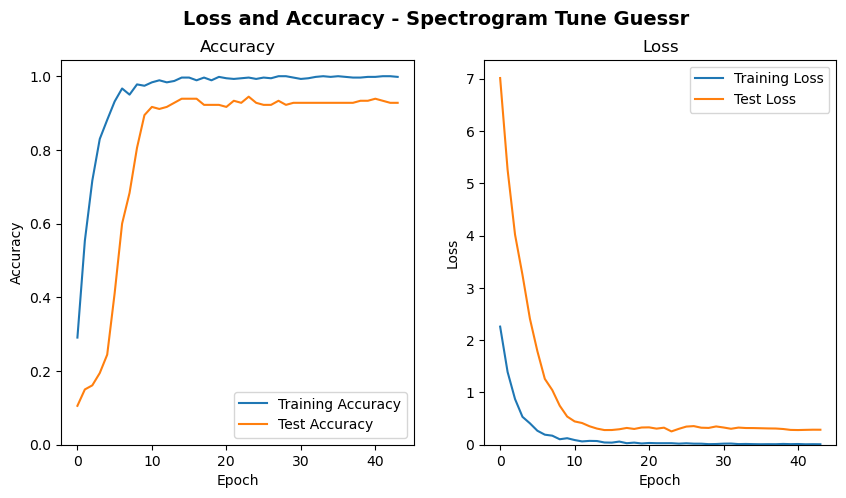

In [15]:
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.suptitle("Loss and Accuracy - Spectrogram Tune Guessr", fontsize=14, fontweight='bold')  

plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.savefig('spectrogram_loss_accuracy.png')
plt.show()

In [19]:
def predict_song_spectrogram(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    segment_samples = int(SAMPLE_RATE * 5)
    num_segments = math.ceil(len(signal) / segment_samples)

    predictions = []

    for s in range(num_segments):
        start = segment_samples * s
        end = start + segment_samples
        segment = signal[start:end]

        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), mode='constant')

        log_spec = extract_spectrogram(segment)
        if log_spec is not None:
            max_len = model.input_shape[2]
            padded_spec = np.pad(log_spec, ((0, 0), (0, max_len - log_spec.shape[1])), mode='constant')
            padded_spec = padded_spec[np.newaxis, ..., np.newaxis]  
            prediction = model.predict(padded_spec)
            predicted_label = np.argmax(prediction)
            predictions.append(predicted_label)

    most_common_label = Counter(predictions).most_common(1)[0][0]
    predicted_song = label_encoder.inverse_transform([most_common_label])[0]

    try:
        artist, song = predicted_song.split("_")
    except ValueError:
        artist, song = predicted_song, "Unknown Title"

    print(f"Predicted Artist: {artist}")
    print(f"Predicted Song: {song}")
    return artist, song

new_file_path = "../dataset_wav/Ardhito Pramono_Dancing In September/Ardhito Pramono_Dancing In September_segment_3.wav"
predicted_artist, predicted_song = predict_song_spectrogram(new_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Artist: Ardhito Pramono
Predicted Song: Dancing In September


In [18]:
model.save("spectrogram_model.keras")